In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks
# Disclaimer: Most of this is unoriginal and ripped directly from a random online tutorial.

In [6]:
data_planet = pd.read_excel("ep206103150.xlsx")

Final parameters:
t0: 2149.974766707306
rp: 0.05008416457412418
per: 4.159362020209585
a: 3.0932342350971087
u1: 0.004379803626030292
u2: 0.0029427276696969654
u3: 0.40371203841155
u4: 0.9975542099217725


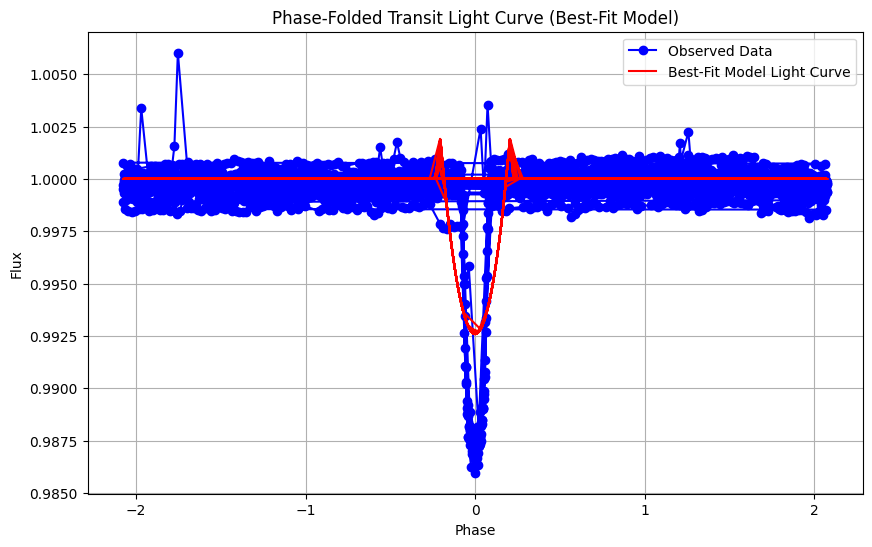

In [11]:
# Load data (provide the path to your dataset)
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        initial_params['t0'] = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = initial_params['t0']
    params.per = initial_params['per']
    params.rp = initial_params['rp']
    params.a = (params.per**2)**(1/3)
    params.inc = initial_params['inc']
    params.ecc = initial_params['ecc']
    params.w = initial_params['w']
    params.limb_dark = "nonlinear"  # Change the limb darkening model
    params.u = [initial_params['u1'], initial_params['u2'], initial_params['u3'], initial_params['u4']]  # Nonlinear limb darkening has 4 parameters

    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.rp, params.per, params.a, params.u[0], params.u[1], params.u[2], params.u[3] = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, rp, per, a, u1, u2, u3, u4)
    initial_guess = [params.t0, params.rp, params.per, params.a, params.u[0], params.u[1], params.u[2], params.u[3]]
    bounds = [(params.t0 - 1, params.t0 + 1), (params.rp * 0.5, params.rp * 2.0),
              (params.per * 0.8, params.per * 1.2), (params.a * 0.8, params.a * 1.2),
              (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]  # Bounds for parameters
    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.rp, params.per, params.a, params.u[0], params.u[1], params.u[2], params.u[3] = best_fit_params

    print("Final parameters:")
    print("t0:", params.t0)
    print("rp:", params.rp)
    print("per:", params.per)
    print("a:", params.a)
    print("u1:", params.u[0])
    print("u2:", params.u[1])
    print("u3:", params.u[2])
    print("u4:", params.u[3])

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, best_fit_params

# Initial parameters (provide initial guesses for the transit parameters)
initial_params = {
    't0': 2150.00,
    'per': 4.1591,
    'rp': 0.1,  # Adjust the initial guess for the planet radius
    'inc': 87.0,
    'ecc': 0.0,
    'w': 90.0,
    'u1': 0.1,  # Adjust the initial guess for the limb darkening parameters
    'u2': 0.1,
    'u3': 0.1,
    'u4': 0.1
}

# Fit the transit parameters and generate the model light curve
model, best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)

# Phase fold the data
folded_time = ((time_data - best_fit_params[0] + 0.5 * best_fit_params[2]) % best_fit_params[2]) - 0.5 * best_fit_params[2]

# Plot the phase-folded light curve
plt.figure(figsize=(10, 6))
plt.plot(folded_time, flux_data, marker='o', linestyle='-', color='b', label='Observed Data')
plt.plot(folded_time, model, color='r', label='Best-Fit Model Light Curve')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-Folded Transit Light Curve (Best-Fit Model)')
plt.legend()
plt.grid(True)
plt.show()
